# LLM Security - Prompt Injection
## Part 3 - Classification Using a Fine-tuned LLM

In this notebook, we load the raw dataset and fine-tune a pre-trained large language model to classify malicious prompts.
> **INPUT:** the raw dataset loaded from Hugging Face library. <br>
> **OUTPUT:** the performance analysis of fine-tuned LLM.


### 1. INITIALIZATION

In [1]:
# Import necessary libraries and modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set display options
pd.set_option('display.max_columns', None)

### 2. LOADING DATASET

Since we are going to use a pre-trained LLM and fine-tune it using the training dataset, we need to load both training and testing data sets.

In [3]:
# Initialize data set location and file name
data_file_path = "../data/raw/"
data_file_name_train = "train-00000-of-00001-9564e8b05b4757ab"
data_file_name_test = "test-00000-of-00001-701d16158af87368"
data_file_ext = ".parquet"

# Loading data set into a pandas DataFrame
data_train = pd.read_parquet(data_file_path + data_file_name_train + data_file_ext)
data_test = pd.read_parquet(data_file_path + data_file_name_test + data_file_ext)

In [4]:
# Rename "text" column into "prompt"
data_train.rename(columns={"text":"prompt"}, inplace=True)
data_test.rename(columns={"text":"prompt"}, inplace=True)

We already explored the dataset in the previous notebooks, so we will directly proceed to the fine-tuning phase.

### 3. MODEL FINE-TUNING

In this experiment, we aim at using a pre-trained LLM and fine-tuning it on the classification task.

In the previous experiment, we used the pre-trained XLM-RoBERTa, the multilingual version of RoBERTa (Robustly optimized BERT approach), the enhanced version of BERT (Bidirectional Encoder Representations from Transformers).

To explore the effect of model fine-tuning, we fine-tune XLM-RoBERTa on our training dataset and then re-evaluate its performance in correctly predicting prompt injections.

In [5]:
# Import the model, its tokenizer, and torch library
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import torch

In [6]:
# Load the model tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')

In [7]:
# A utility function to receive a batch of data and tokenize the prompts
def tokenize_batch(batch):
    return tokenizer(batch['prompt'], padding=True, truncation=True)

In [8]:
# Tokenize prompts in both training and testing datasets
prompts_train_tokenized = tokenize_batch(data_train.to_dict(orient='list'))
prompts_test_tokenized = tokenize_batch(data_test.to_dict(orient='list'))

In [9]:
# Define a dataset Class to work with PyTorch's DataLoader
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [10]:
# Prepare CustomDataset for training and testing to be used by the LLM
train_dataset = CustomDataset(prompts_train_tokenized, data_train['label'])
test_dataset = CustomDataset(prompts_test_tokenized, data_test['label'])

In [11]:
# Load pre-trained Model
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-large', num_labels=2)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


When loading the model, we get this message indicating that some weights are not initialized. This is normal since the model is pre-trained but not fine-tuned for the downstream task.

In [12]:
# Import TrainingArguments to handle the various training configurations
from transformers import TrainingArguments

# Define training arguments for fine-tuning
training_args = TrainingArguments(
    output_dir="../output",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    logging_dir="../output/logs",
)

In [13]:
# Initialize a DataFrame to track the model's performance
results_df = pd.DataFrame(columns=["epoch","accuracy","precision","recall","f1"])

In [14]:
# Import accuracy metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# A utility function for model evaluation during fine-tuning
def evaluate_model(trainer, epoch):
    
    # Extract predictions and labels
    predictions, labels = trainer.predictions.argmax(axis=1), trainer.label_ids
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    
    # Calculate precision, recall, and f1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions)
    
    # Append current metrics to results
    global results_df
    results_df.loc[len(results_df)] = [epoch, accuracy, precision, recall, f1]
        
    # Return
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [15]:
# Import the Trainer class
from transformers import Trainer

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: evaluate_model(p, trainer.state.epoch),
)

In [16]:
# Fine-tune the model
trainer.train()

  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.5706355571746826, 'eval_accuracy': 0.75, 'eval_precision': 0.8214676889375684, 'eval_recall': 0.75, 'eval_f1': 0.7379902529589232, 'eval_runtime': 4.1844, 'eval_samples_per_second': 27.722, 'eval_steps_per_second': 3.585, 'epoch': 1.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.1885787844657898, 'eval_accuracy': 0.9396551724137931, 'eval_precision': 0.9431111567912019, 'eval_recall': 0.9396551724137931, 'eval_f1': 0.9396327477286996, 'eval_runtime': 7.2185, 'eval_samples_per_second': 16.07, 'eval_steps_per_second': 2.078, 'epoch': 2.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.28478938341140747, 'eval_accuracy': 0.9568965517241379, 'eval_precision': 0.9604296212549464, 'eval_recall': 0.9568965517241379, 'eval_f1': 0.9568805340919283, 'eval_runtime': 6.7107, 'eval_samples_per_second': 17.286, 'eval_steps_per_second': 2.235, 'epoch': 3.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.25964948534965515, 'eval_accuracy': 0.9482758620689655, 'eval_precision': 0.9505336617405583, 'eval_recall': 0.9482758620689655, 'eval_f1': 0.9482758620689654, 'eval_runtime': 6.6096, 'eval_samples_per_second': 17.55, 'eval_steps_per_second': 2.269, 'epoch': 4.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.3735761046409607, 'eval_accuracy': 0.9396551724137931, 'eval_precision': 0.946360153256705, 'eval_recall': 0.9396551724137931, 'eval_f1': 0.9395609327038719, 'eval_runtime': 7.2499, 'eval_samples_per_second': 16.0, 'eval_steps_per_second': 2.069, 'epoch': 5.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.33268141746520996, 'eval_accuracy': 0.9568965517241379, 'eval_precision': 0.9604296212549464, 'eval_recall': 0.9568965517241379, 'eval_f1': 0.9568805340919283, 'eval_runtime': 7.1767, 'eval_samples_per_second': 16.163, 'eval_steps_per_second': 2.09, 'epoch': 6.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.5187273025512695, 'eval_accuracy': 0.9482758620689655, 'eval_precision': 0.9532814238042269, 'eval_recall': 0.9482758620689655, 'eval_f1': 0.9482297210003383, 'eval_runtime': 7.6758, 'eval_samples_per_second': 15.112, 'eval_steps_per_second': 1.954, 'epoch': 7.0}
{'loss': 0.1825, 'learning_rate': 5.507246376811595e-06, 'epoch': 7.25}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.20927822589874268, 'eval_accuracy': 0.9741379310344828, 'eval_precision': 0.9742942979892748, 'eval_recall': 0.9741379310344828, 'eval_f1': 0.9741437008126411, 'eval_runtime': 7.6885, 'eval_samples_per_second': 15.087, 'eval_steps_per_second': 1.951, 'epoch': 8.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.2154473215341568, 'eval_accuracy': 0.9741379310344828, 'eval_precision': 0.9742942979892748, 'eval_recall': 0.9741379310344828, 'eval_f1': 0.9741437008126411, 'eval_runtime': 8.0582, 'eval_samples_per_second': 14.395, 'eval_steps_per_second': 1.861, 'epoch': 9.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.2176482379436493, 'eval_accuracy': 0.9741379310344828, 'eval_precision': 0.9742942979892748, 'eval_recall': 0.9741379310344828, 'eval_f1': 0.9741437008126411, 'eval_runtime': 8.062, 'eval_samples_per_second': 14.389, 'eval_steps_per_second': 1.861, 'epoch': 10.0}
{'train_runtime': 12865.272, 'train_samples_per_second': 0.424, 'train_steps_per_second': 0.054, 'train_loss': 0.13419939486876778, 'epoch': 10.0}


TrainOutput(global_step=690, training_loss=0.13419939486876778, metrics={'train_runtime': 12865.272, 'train_samples_per_second': 0.424, 'train_steps_per_second': 0.054, 'train_loss': 0.13419939486876778, 'epoch': 10.0})

In [17]:
# Print detailed results
results_df

,epoch,accuracy,precision,recall,f1
0,1.0,0.750000,0.821468,0.750000,0.737990
1,2.0,0.939655,0.943111,0.939655,0.939633
2,3.0,0.956897,0.960430,0.956897,0.956881
3,4.0,0.948276,0.950534,0.948276,0.948276
4,5.0,0.939655,0.946360,0.939655,0.939561
5,6.0,0.956897,0.960430,0.956897,0.956881
6,7.0,0.948276,0.953281,0.948276,0.948230
7,8.0,0.974138,0.974294,0.974138,0.974144
8,9.0,0.974138,0.974294,0.974138,0.974144
9,10.0,0.974138,0.974294,0.974138,0.974144


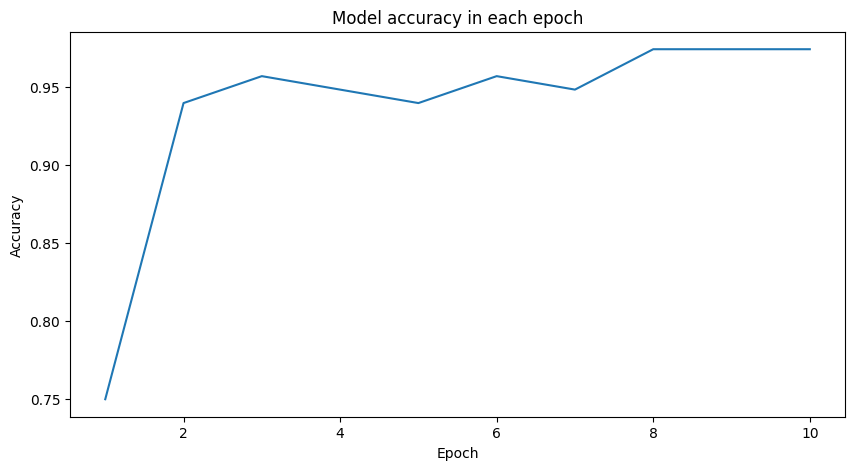

In [18]:
# Plot the accuracy in each epoch

# Create a figure
plt.figure(figsize=(10,5))

# Plot samples
sns.lineplot(data=results_df, x="epoch", y="accuracy")

# Set figure title and axes labels
plt.title("Model accuracy in each epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Show the plot
plt.show()

Here is our reading of this chart and epoch performance:
- Accuracy: The accuracy starts at 75% in the first epoch and steadily improves, reaching a high of 97.4% in the later epochs. The model shows consistent high accuracy from the 7th to the 10th epoch.
- Precision: It measures the accuracy of the positive predictions. It starts at 82.15% and consistently improves, reaching 97.43% in the later epochs. Like accuracy, precision stabilizes from the 7th epoch onward.
- Recall: It measures the ability of the model to capture all positive instances. It starts at 75% and maintains a high level throughout, reaching 97.41% in the later epochs. Similar to precision, recall stabilizes from the 7th epoch onward.
- F1 Score: The F1 score is the harmonic mean of precision and recall. It starts at 73.80% and steadily improves, reaching 97.41% in the later epochs. Similar to accuracy, precision, and recall, the F1 score stabilizes from the 7th epoch onward.
Overall, the model performs well, showing a consistent improvement in all metrics over epochs.

In [19]:
# Evaluate the final model
final_results = trainer.evaluate()
print(final_results)

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.2176482379436493, 'eval_accuracy': 0.9741379310344828, 'eval_precision': 0.9742942979892748, 'eval_recall': 0.9741379310344828, 'eval_f1': 0.9741437008126411, 'eval_runtime': 2.2458, 'eval_samples_per_second': 51.652, 'eval_steps_per_second': 6.679, 'epoch': 10.0}


The fine-tuning is finished now, we will save the model to a local path.

This step is preferred so we can reload it later for evaluation and inference without the need to repeat the fine-tuning process.

In [20]:
# Set local model path
models_path = "../models/xlm_roberta"

In [21]:
# Save the model and tokenizer for a later use 
model.save_pretrained(models_path)
tokenizer.save_pretrained(models_path)

('../models/xlm_roberta\\tokenizer_config.json',
 '../models/xlm_roberta\\special_tokens_map.json',
 '../models/xlm_roberta\\sentencepiece.bpe.model',
 '../models/xlm_roberta\\added_tokens.json')

### 4. RESULT ANALYSIS

In [22]:
# Load the locally-stored fine-tuned model
model = XLMRobertaForSequenceClassification.from_pretrained(models_path)

In [23]:
# Evaluate the final model
final_results = trainer.evaluate()
print(final_results)

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.2176482379436493, 'eval_accuracy': 0.9741379310344828, 'eval_precision': 0.9742942979892748, 'eval_recall': 0.9741379310344828, 'eval_f1': 0.9741437008126411, 'eval_runtime': 2.4071, 'eval_samples_per_second': 48.191, 'eval_steps_per_second': 6.232, 'epoch': 10.0}


The final results demonstrate the following:
- The model achieved impressive accuracy, which suggests that the model is effective in making correct predictions for the prompt injection classification problem.
- The precision indicates that when the model predicts a positive class, it is correct most of the time.
- The high recall also indicates that the model is able to capture the majority of the actual positive instances.
- The F1 score is high and suggests that the model is performing well in both precision and recall.

Overall, the results indicate that the fine-tuned RoBERTa model is highly effective for the classification task, achieving a high level of accuracy, precision, recall, and F1 score. A next step might be to further analyze the wrong predictions to make sense of any potential patterns the model might have missed or was unable to capture in the dataset.

**Having these metrics in mind, and comparing the performance obtained here with all other experiments we have done in the other notebooks, we state that the fine-tuned LLM surpassed all other methods and achieved the highest accuracy in predicting prompt injections.**
